In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Recommended: import the stable helper from the Python module
from data_utils import get_clean_X_y
X, y = get_clean_X_y()
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (5644, 98)
y shape: (5644,)


In [5]:
# Create a train/test split for modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4515, 98), (1129, 98), (4515,), (1129,))

In [6]:
# Train a Gaussian Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB
# for evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Training metrics
print('Training accuracy:', gnb.score(X_train, y_train))

# Calculate MSE using probability predictions
# Convert labels to numeric for MSE calculation
y_train_numeric = (y_train == 'p').astype(int)
y_test_numeric = (y_test == 'p').astype(int)

# Get probability predictions for positive class (poisonous)
y_train_proba = gnb.predict_proba(X_train)[:, 1]
y_test_proba = gnb.predict_proba(X_test)[:, 1]

# Calculate MSE
train_mse = mean_squared_error(y_train_numeric, y_train_proba)
test_mse = mean_squared_error(y_test_numeric, y_test_proba)

print(f'Training MSE: {train_mse:.6f}')
print(f'Test MSE: {test_mse:.6f}')

Training accuracy: 0.9991140642303433
Training MSE: 0.000886
Test MSE: 0.003543


In [7]:
# Cross-validation on the training set (5-fold) to estimate generalization
from sklearn.model_selection import cross_val_score
# parameters are model aka estimator, training Data, y training, k value in k-fold, what we're scoring on,
# and whether or not we want parallelization (multithreading) default is 0, 1 is yes
# outputs array of scores
cv_scores = cross_val_score(GaussianNB(), X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print('CV scores (5-fold) on training set:', cv_scores)
print('CV mean accuracy:', cv_scores.mean(), 'std:', cv_scores.std())

CV scores (5-fold) on training set: [0.99889258 0.99778516 1.         0.99889258 1.        ]
CV mean accuracy: 0.9991140642303433 std: 0.0008287170291858253


In [8]:
# Evaluate on the test set
y_pred = gnb.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_pred))
print('')
print('Classification report:\n', classification_report(y_test, y_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))

Test accuracy: 0.9964570416297609

Classification report:
               precision    recall  f1-score   support

           e       1.00      0.99      1.00       693
           p       0.99      1.00      1.00       436

    accuracy                           1.00      1129
   macro avg       1.00      1.00      1.00      1129
weighted avg       1.00      1.00      1.00      1129

Confusion matrix:
 [[689   4]
 [  0 436]]


In [9]:
# Nested stratified cross-validation (outer CV for unbiased estimate)
from sklearn.model_selection import StratifiedKFold, cross_val_score
import joblib

# inner CV used by GridSearch (for hyperparameter tuning)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# outer CV used by cross_val_score to get an unbiased generalization estimate
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Expanded parameter grid for var_smoothing
param_grid = {'var_smoothing': np.logspace(-10, -6, 20)}

base = GaussianNB()
grid_nested = GridSearchCV(base, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1, verbose=2)

print(f"Running nested CV (outer_cv={outer_cv.get_n_splits()}, inner_cv={inner_cv.get_n_splits()}) — this may take a while...")
nested_scores = cross_val_score(grid_nested, X, y, cv=outer_cv, scoring='accuracy', n_jobs=-1)
print('Nested CV accuracy: mean={:.4f}, std={:.4f}'.format(nested_scores.mean(), nested_scores.std()))

# Refit GridSearch on the entire dataset (inner CV) to obtain final model
print('Refitting GridSearchCV on full data to get final estimator...')
grid_nested.fit(X, y)
print('Best params on full data:', grid_nested.best_params_)
print('Best inner-CV score on full data:', grid_nested.best_score_)

best_final = grid_nested.best_estimator_
joblib.dump(best_final, 'naivebayes_best_model_nested.joblib')
print('Saved final model to naivebayes_best_model_nested.joblib')

# Evaluate the final model on the held-out test set from the earlier stratified split
y_test_pred = best_final.predict(X_test)
print('Test accuracy (final model):', accuracy_score(y_test, y_test_pred))
print('\nClassification report:\n', classification_report(y_test, y_test_pred))

#update model
gnb = best_final

NameError: name 'GridSearchCV' is not defined

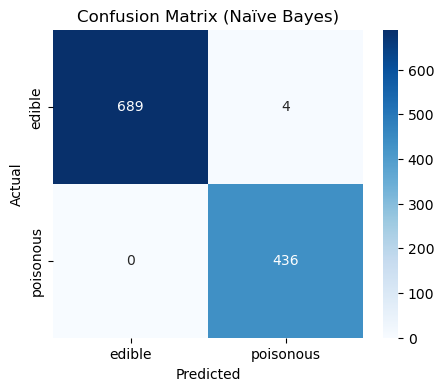

In [ ]:
# Confusion matrix visualization
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['edible','poisonous'], yticklabels=['edible','poisonous'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Naïve Bayes)')
plt.show()

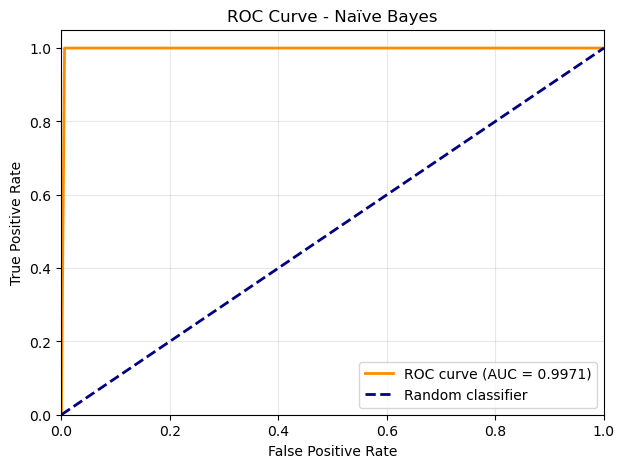

AUC Score: 0.9971


In [ ]:
# ROC Curve visualization
# Import functions to compute ROC curve metrics and plot
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get prediction probabilities for the positive class
# predict_proba returns 2D array: [prob_class_0, prob_class_1] for each sample
# [:, 1] selects the second column (probability of positive class)
y_test_proba = gnb.predict_proba(X_test)[:, 1]

# Determine which class is positive (assuming 'p' for poisonous)
# Get the class labels from the trained model (e.g., ['e', 'p'])
classes = gnb.classes_
# Check if 'p' exists in classes, otherwise use the second class as positive
pos_label = 'p' if 'p' in classes else classes[1]

# Calculate ROC curve
# fpr = False Positive Rate (x-axis): FP / (FP + TN)
# tpr = True Positive Rate (y-axis): TP / (TP + FN), also called "Recall" 
# thresholds = probability cutoffs used to determine class assignment
# pos_label specifies which class is considered "positive" for binary classification
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba, pos_label=pos_label)

# Calculate Area Under the ROC Curve (AUC)
auc_score = roc_auc_score(y_test, y_test_proba)

# Plot ROC curve
# Create a figure with sizes: width=7 units, height=5 units)
plt.figure(figsize=(7, 5))
# Plot the ROC curve: darkorange line, linewidth=2, with label showing AUC score up to 4 decimal 
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
# Plot diagonal reference line representing a baseline of (50% accuracy)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
# x-axis limits
plt.xlim([0.0, 1.0])
# y-axis limits
plt.ylim([0.0, 1.05])
# Label x-axis
plt.xlabel('False Positive Rate')
# Label y-axis
plt.ylabel('True Positive Rate')
# Set plot title
plt.title('ROC Curve - Naïve Bayes')
# Add legend in lower right corner
plt.legend(loc="lower right")
# Add light grid lines for easier reading (alpha is the opacity of lines)
plt.grid(alpha=0.3)
# Display the plot
plt.show()

# Print the AUC score with 4 decimal places
print(f'AUC Score: {auc_score:.4f}')

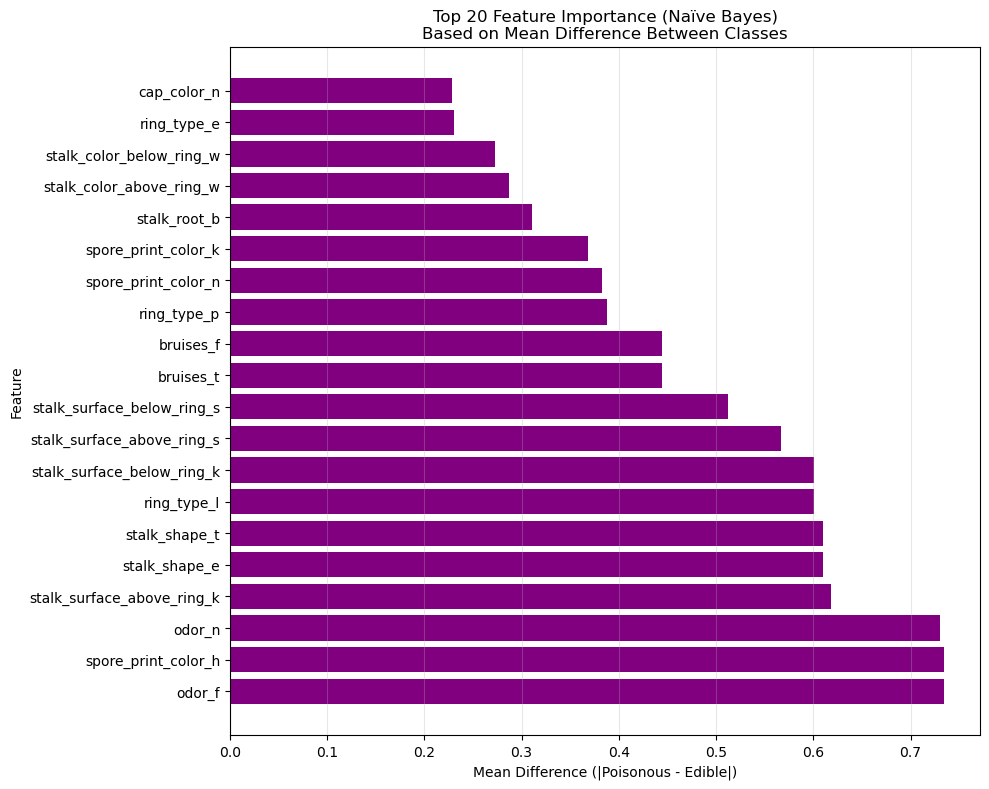


Total features: 98

Top 5 most discriminative features:
                       feature  importance
22                      odor_f    0.734694
80         spore_print_color_h    0.734694
25                      odor_n    0.729826
49  stalk_surface_above_ring_k    0.617811
42               stalk_shape_e    0.609539


In [ ]:
# Feature Importance for Naïve Bayes
# For Gaussian Naive Bayes, we can examine the log probability differences between classes
# Features with larger differences are more important for classification

import seaborn as sns

# Get the indices for each class
class_indices = {cls: idx for idx, cls in enumerate(gnb.classes_)}
edible_idx = class_indices.get('e', 0)
poisonous_idx = class_indices.get('p', 1)

# Calculate mean values for each feature per class (from training data)
# theta_ contains the mean of each feature per class
feature_means_edible = gnb.theta_[edible_idx]
feature_means_poisonous = gnb.theta_[poisonous_idx]

# Calculate the log probability ratio (importance measure)
# Higher numerical values values indicate more discriminative features
feature_importance = np.abs(feature_means_poisonous - feature_means_edible)

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importance,
    'edible_mean': feature_means_edible,
    'poisonous_mean': feature_means_poisonous
})

# Sort and get top 20
top_features = importance_df.sort_values('importance', ascending=False).head(20)

# Plot top 20 features
plt.figure(figsize=(10, 8))
plt.barh(range(len(top_features)), top_features['importance'], color='purple')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Mean Difference (|Poisonous - Edible|)')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance (Naïve Bayes)\nBased on Mean Difference Between Classes')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f'\nTotal features: {len(X.columns)}')
print(f'\nTop 5 most discriminative features:')
print(top_features[['feature', 'importance']].head())